In [26]:
import pandas as pd
import pm4py
from helpers import get_field_position
from pm4py.objects.ocel.util.log_ocel import log_to_ocel_multiple_obj_types as log_to_ocel

In [60]:
df = pd.read_csv('sample-data\data\Sample_Game_1\Sample_Game_1_RawEventsData.csv')
df['case:concept:name'] = df.index.astype(str)
#df['activity'] = df['Type'] #+ df['Subtype'].fillna('').apply(lambda s: f' - {s}' if s else '')
df['timestamp'] = pd.to_datetime(df['Start Time [s]'], unit='s', origin='unix')
df['attribute:duration'] = df['End Time [s]'] - df['Start Time [s]']
#df['player']= df.apply(lambda row: [row["From"], row["To"]], axis=1)
df['attribute:travel_distance'] = ((df['End X'] - df['Start X'])**2 + (df['End Y'] - df['Start Y'])**2)**0.5
df['start_grid'] = df.apply(lambda row: [get_field_position(row["Start X"], row["Start Y"], x_fields=10, y_fields=10)], axis=1)
df['end_grid'] = df.apply(lambda row: [get_field_position(row["End X"], row["End Y"], x_fields=10, y_fields=10)], axis=1)
df['crossed_grid'] = df['start_grid'] != df['end_grid']
#df['attack'] = ((df['Type'] == 'SET PIECE') | (df['Type'] == 'RECOVERY')).cumsum()

attack_id_away = 0
attack_id_home = 0
current_team = None
attack_ids = []
for i, row in df.iterrows():
    event = row['Type']
    if event in ['SET PIECE', 'RECOVERY']:
        current_team = row['Team']
        if current_team == 'Away':
            attack_id_away += 1
            attack_id = 'AA'+str(attack_id_away)
        else:
            attack_id_home += 1
            attack_id = 'HA'+str(attack_id_home)
    attack_ids.append(attack_id)

df['attack'] = attack_ids

df.rename(columns={
    #'Team': 'case:concept:name',
    'Type': 'concept:name',
    'timestamp': 'time:timestamp',
    #'From': 'ocel:type:from',
    #'To': 'ocel:type:to',
    'Subtype': 'attribute:subtype',
    'Start X': 'attribute:start_x',
    'Start Y': 'attribute:start_y',
    'End X': 'attribute:end_x',
    'End Y': 'attribute:end_y'
}, inplace=True)
df
#df.to_csv('sample-data\data\Sample_Game_1\Sample_Game_1_RawEventsData_ocel.csv', index=False)

,Team,concept:name,attribute:subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,...,attribute:end_x,attribute:end_y,case:concept:name,time:timestamp,attribute:duration,attribute:travel_distance,start_grid,end_grid,crossed_grid,attack
0,Away,SET PIECE,KICK OFF,1,1,0.04,0,0.00,Player19,NaN,...,NaN,NaN,0,1970-01-01 00:00:00.040,-0.04,NaN,[None],[None],False,AA1
1,Away,PASS,NaN,1,1,0.04,3,0.12,Player19,Player21,...,0.55,0.43,1,1970-01-01 00:00:00.040,0.08,0.107703,[E4],[F5],True,AA1
2,Away,PASS,NaN,1,3,0.12,17,0.68,Player21,Player15,...,0.58,0.21,2,1970-01-01 00:00:00.120,0.56,0.222036,[F5],[F3],True,AA1
3,Away,PASS,NaN,1,45,1.80,61,2.44,Player15,Player19,...,0.45,0.31,3,1970-01-01 00:00:01.800,0.64,0.156205,[F2],[E4],True,AA1
4,Away,PASS,NaN,1,77,3.08,96,3.84,Player19,Player21,...,0.49,0.47,4,1970-01-01 00:00:03.080,0.76,0.155242,[E4],[E5],True,AA1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1740,Home,PASS,NaN,2,143361,5734.44,143483,5739.32,Player12,Player13,...,0.19,0.95,1740,1970-01-01 01:35:34.440,4.88,0.743303,[G4],[B10],True,HA180
1741,Home,PASS,NaN,2,143578,5743.12,143593,5743.72,Player13,Player4,...,0.14,0.69,1741,1970-01-01 01:35:43.120,0.60,0.196469,[A9],[B7],True,HA180
1742,Home,BALL LOST,INTERCEPTION,2,143598,5743.92,143618,5744.72,Player4,NaN,...,0.07,0.61,1742,1970-01-01 01:35:43.920,0.80,0.100000,[B7],[A7],True,HA180
1743,Away,RECOVERY,BLOCKED,2,143617,5744.68,143617,5744.68,Player16,NaN,...,NaN,NaN,1743,1970-01-01 01:35:44.680,0.00,NaN,[A7],[None],True,AA175


In [47]:
np.unique(df['concept:name'])

array(['BALL LOST', 'BALL OUT', 'CARD', 'CHALLENGE', 'FAULT RECEIVED',
       'PASS', 'RECOVERY', 'SET PIECE', 'SHOT'], dtype=object)

In [ ]:
np.unique(df['concept:name'])

,Team,concept:name,attribute:subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,...,attribute:start_y,attribute:end_x,attribute:end_y,case:concept:name,time:timestamp,attribute:duration,attribute:travel_distance,start_grid,end_grid,crossed_grid
30,Away,BALL OUT,NaN,1,1374,54.96,1425,57.00,Player15,NaN,...,0.29,1.05,0.17,30,1970-01-01 00:00:54.960,2.04,0.216333,[D2],[E1],True
41,Away,BALL OUT,NaN,1,4093,163.72,4164,166.56,Player25,NaN,...,0.56,0.49,1.04,41,1970-01-01 00:02:43.720,2.84,0.651153,[D3],[B5],True
52,Home,BALL OUT,NaN,1,4751,190.04,4836,193.44,Player7,NaN,...,0.78,0.67,1.03,52,1970-01-01 00:03:10.040,3.40,0.375366,[B4],[C5],True
122,Home,BALL OUT,NaN,1,8753,350.12,8843,353.72,Player8,NaN,...,0.21,0.74,-0.04,122,1970-01-01 00:05:50.120,3.60,0.265707,[C1],[C1],False
127,Home,BALL OUT,NaN,1,9098,363.92,9127,365.08,Player3,NaN,...,0.10,0.05,-0.04,127,1970-01-01 00:06:03.920,1.16,0.143178,[A1],[A1],False
137,Away,BALL OUT,NaN,1,9634,385.36,9663,386.52,Player25,NaN,...,0.44,1.03,0.33,137,1970-01-01 00:06:25.360,1.16,0.125300,[D2],[E2],True
164,Home,BALL OUT,HEAD-CLEARANCE,1,12033,481.32,12047,481.88,Player1,NaN,...,0.62,-0.05,0.71,164,1970-01-01 00:08:01.320,0.56,0.127279,[A3],[A3],False
166,Away,BALL OUT,NaN,1,12636,505.44,12702,508.08,Player21,NaN,...,0.95,-0.03,0.34,166,1970-01-01 00:08:25.440,2.64,0.611310,[A4],[A2],True
182,Away,BALL OUT,CLEARANCE,1,13886,555.44,13987,559.48,Player16,NaN,...,0.48,0.96,-0.04,182,1970-01-01 00:09:15.440,4.04,0.524690,[D2],[D1],True
229,Away,BALL OUT,NaN,1,16471,658.84,16543,661.72,Player15,NaN,...,0.13,1.03,0.20,229,1970-01-01 00:10:58.840,2.88,0.240416,[D1],[E1],True


In [63]:
df.iloc[1090:1100]

,Team,concept:name,attribute:subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,...,attribute:end_x,attribute:end_y,case:concept:name,time:timestamp,attribute:duration,attribute:travel_distance,start_grid,end_grid,crossed_grid,attack
1090,Away,SET PIECE,CORNER KICK,2,87411,3496.44,87411,3496.44,Player19,NaN,...,NaN,NaN,1090,1970-01-01 00:58:16.440,0.00,NaN,[None],[None],False,AA115
1091,Away,BALL LOST,INTERCEPTION,2,87411,3496.44,87470,3498.80,Player19,NaN,...,0.98,0.48,1091,1970-01-01 00:58:16.440,2.36,0.490408,[J10],[J5],True,AA115
1092,Home,RECOVERY,INTERCEPTION,2,87470,3498.80,87470,3498.80,Player5,NaN,...,NaN,NaN,1092,1970-01-01 00:58:18.800,0.00,NaN,[J5],[None],True,HA118
1093,Home,BALL OUT,WOODWORK-GOAL,2,87470,3498.80,87485,3499.40,Player5,NaN,...,1.01,0.54,1093,1970-01-01 00:58:18.800,0.60,0.072111,[J5],[K6],True,HA118
1094,Home,SET PIECE,KICK OFF,2,88792,3551.68,88792,3551.68,Player10,NaN,...,NaN,NaN,1094,1970-01-01 00:59:11.680,0.00,NaN,[None],[None],False,HA119
1095,Home,PASS,NaN,2,88792,3551.68,88820,3552.80,Player10,Player12,...,0.56,0.41,1095,1970-01-01 00:59:11.680,1.12,0.114018,[E6],[F5],True,HA119
1096,Home,PASS,NaN,2,88820,3552.80,88847,3553.88,Player12,Player6,...,0.56,0.55,1096,1970-01-01 00:59:12.800,1.08,0.140000,[F5],[F6],True,HA119
1097,Away,CHALLENGE,GROUND-FAULT-LOST,2,88886,3555.44,88886,3555.44,Player24,NaN,...,NaN,NaN,1097,1970-01-01 00:59:15.440,0.00,NaN,[F6],[None],True,HA119
1098,Home,CHALLENGE,TACKLE-FAULT-WON,2,88912,3556.48,88912,3556.48,Player6,NaN,...,NaN,NaN,1098,1970-01-01 00:59:16.480,0.00,NaN,[F6],[None],True,HA119
1099,Home,FAULT RECEIVED,NaN,2,88912,3556.48,88912,3556.48,Player6,NaN,...,NaN,NaN,1099,1970-01-01 00:59:16.480,0.00,NaN,[F6],[None],True,HA119


In [65]:
df[df['attribute:subtype'].str.contains('GOAL', na=False)&(df['attribute:subtype'] != 'GOAL KICK')]

,Team,concept:name,attribute:subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,...,attribute:end_x,attribute:end_y,case:concept:name,time:timestamp,attribute:duration,attribute:travel_distance,start_grid,end_grid,crossed_grid,attack
34,Home,SHOT,HEAD-ON TARGET-GOAL,1,2289,91.56,2309,92.36,Player9,NaN,...,1.01,0.55,34,1970-01-01 00:01:31.560,0.80,0.120416,[J5],[K6],True,HA4
112,Home,BALL LOST,GOAL KICK-INTERCEPTION,1,8482,339.28,8576,343.04,Player11,NaN,...,0.64,0.38,112,1970-01-01 00:05:39.280,3.76,0.616117,[A6],[G4],True,HA15
293,Home,BALL LOST,GOAL KICK-INTERCEPTION,1,22578,903.12,22661,906.44,Player11,NaN,...,0.60,0.87,293,1970-01-01 00:15:03.120,3.32,0.665733,[A6],[G9],True,HA38
364,Away,BALL LOST,GOAL KICK-INTERCEPTION,1,27247,1089.88,27330,1093.20,Player25,NaN,...,0.44,0.12,364,1970-01-01 00:18:09.880,3.32,0.612944,[J5],[E2],True,AA48
443,Home,BALL LOST,GOAL KICK-INTERCEPTION,1,33645,1345.80,33723,1348.92,Player11,NaN,...,0.61,0.85,443,1970-01-01 00:22:25.800,3.12,0.668880,[A6],[G9],True,HA55
1093,Home,BALL OUT,WOODWORK-GOAL,2,87470,3498.80,87485,3499.40,Player5,NaN,...,1.01,0.54,1093,1970-01-01 00:58:18.800,0.60,0.072111,[J5],[K6],True,HA118
1114,Home,SHOT,ON TARGET-GOAL,2,90005,3600.20,90026,3601.04,Player10,NaN,...,0.00,0.54,1114,1970-01-01 01:00:00.200,0.84,0.243516,[A4],[A6],True,HA121
1189,Home,BALL LOST,GOAL KICK-INTERCEPTION,2,98069,3922.76,98139,3925.56,Player11,NaN,...,0.33,0.63,1189,1970-01-01 01:05:22.760,2.80,0.650000,[J5],[D7],True,HA130
1213,Home,SHOT,ON TARGET-GOAL,2,99032,3961.28,99046,3961.84,Player9,NaN,...,-0.01,0.51,1213,1970-01-01 01:06:01.280,0.56,0.042426,[A6],[A6],False,HA133


In [68]:
event_log = pm4py.convert_to_event_log(df)

ocel= log_to_ocel(event_log, activity_column='concept:name', timestamp_column='time:timestamp', obj_types=['Team','From', 'To', 'attack']
                  ,additional_event_attributes=['attribute:subtype', 'attribute:start_x', 'attribute:start_y', 'attribute:end_x'
                                                , 'attribute:end_y', 'attribute:duration', 'attribute:travel_distance', 'start_grid'
                                                , 'end_grid', 'crossed_grid'])

In [69]:
ocel.get_extended_table()

,ocel:eid,ocel:activity,ocel:timestamp,attribute:subtype,attribute:duration,start_grid,end_grid,crossed_grid,attribute:start_x,attribute:start_y,attribute:end_x,attribute:end_y,attribute:travel_distance,ocel:type:Team,ocel:type:From,ocel:type:attack,ocel:type:To
0,0,SET PIECE,1970-01-01 00:00:00.040,KICK OFF,-0.04,[None],[None],False,NaN,NaN,NaN,NaN,NaN,[Away],[Player19],[AA1],NaN
1,1,PASS,1970-01-01 00:00:00.040,NaN,0.08,[E4],[F5],True,0.45,0.39,0.55,0.43,0.107703,[Away],[Player19],[AA1],[Player21]
2,2,PASS,1970-01-01 00:00:00.120,NaN,0.56,[F5],[F3],True,0.55,0.43,0.58,0.21,0.222036,[Away],[Player21],[AA1],[Player15]
3,3,PASS,1970-01-01 00:00:01.800,NaN,0.64,[F2],[E4],True,0.55,0.19,0.45,0.31,0.156205,[Away],[Player15],[AA1],[Player19]
4,4,PASS,1970-01-01 00:00:03.080,NaN,0.76,[E4],[E5],True,0.45,0.32,0.49,0.47,0.155242,[Away],[Player19],[AA1],[Player21]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1740,1740,PASS,1970-01-01 01:35:34.440,NaN,4.88,[G4],[B10],True,0.60,0.33,0.19,0.95,0.743303,[Home],[Player12],[HA180],[Player13]
1741,1741,PASS,1970-01-01 01:35:43.120,NaN,0.60,[A9],[B7],True,0.09,0.88,0.14,0.69,0.196469,[Home],[Player13],[HA180],[Player4]
1742,1742,BALL LOST,1970-01-01 01:35:43.920,INTERCEPTION,0.80,[B7],[A7],True,0.13,0.69,0.07,0.61,0.100000,[Home],[Player4],[HA180],NaN
1743,1743,RECOVERY,1970-01-01 01:35:44.680,BLOCKED,0.00,[A7],[None],True,0.05,0.62,NaN,NaN,NaN,[Away],[Player16],[AA175],NaN


In [71]:
path = "game1.jsonocel"
pm4py.write_ocel(ocel, path)

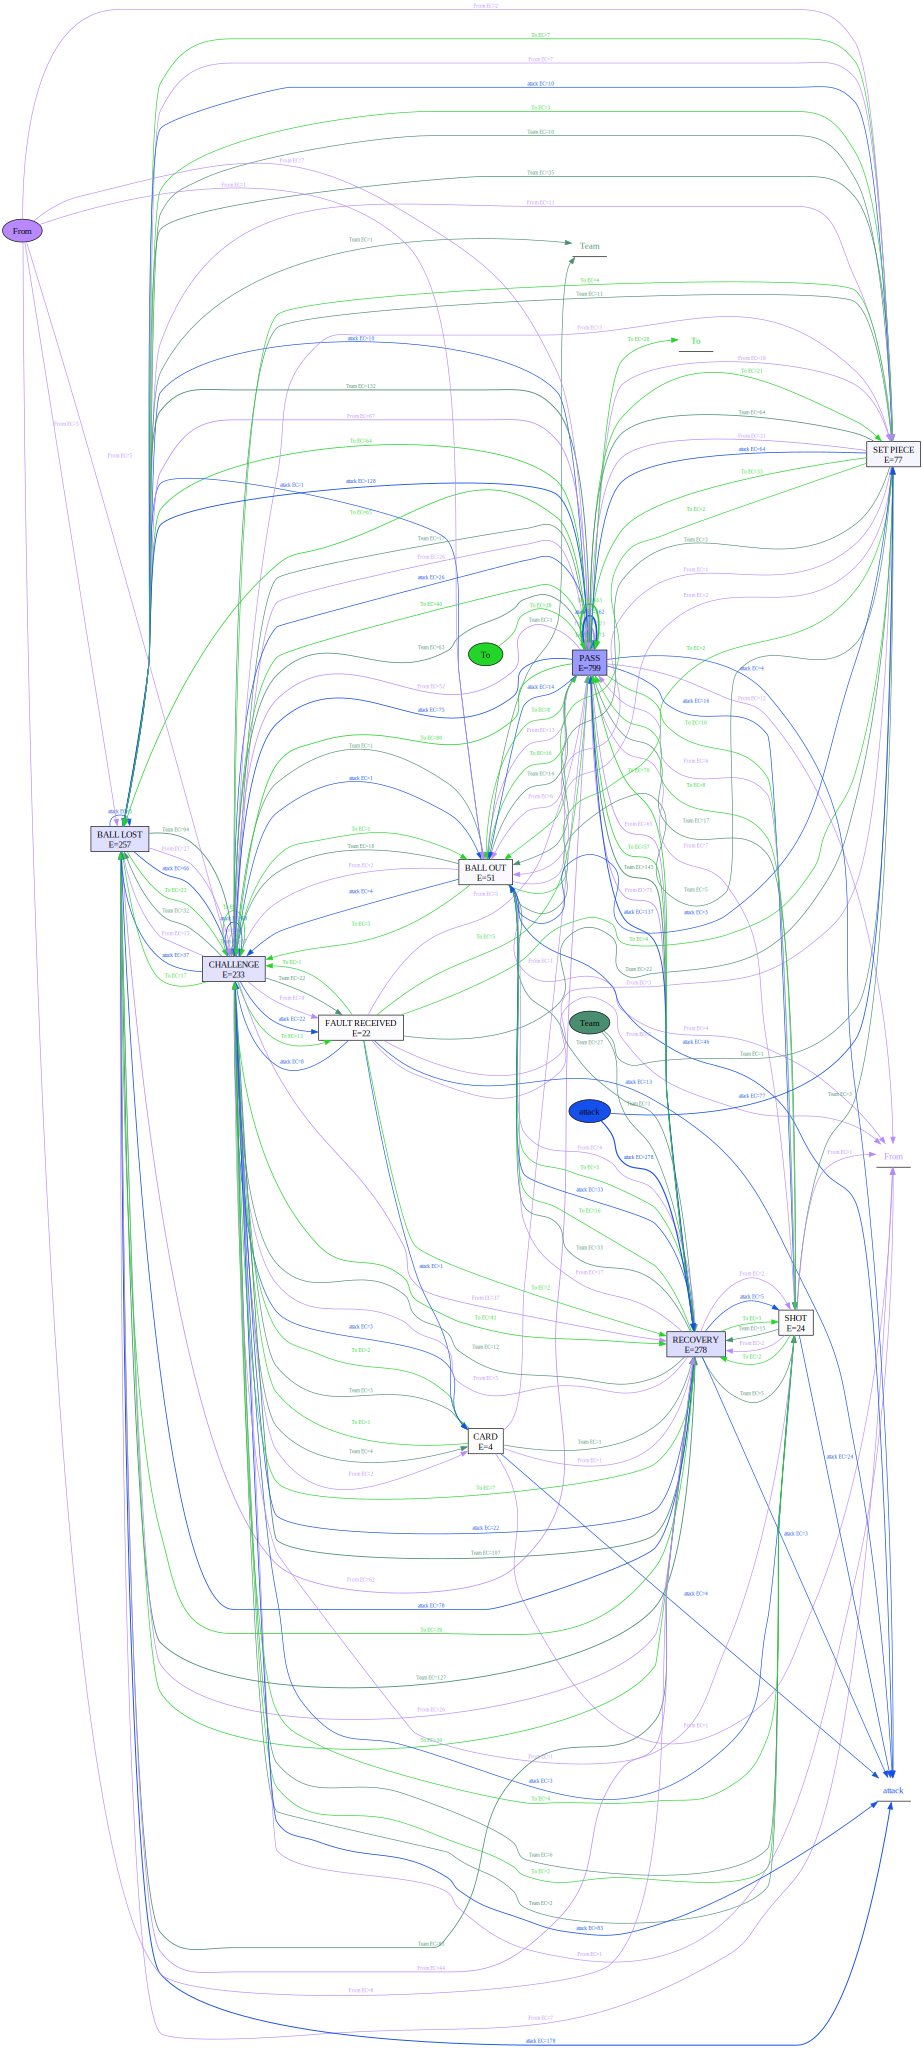

In [70]:
dfg=pm4py.ocel.discover_ocdfg(ocel)
pm4py.visualization.ocel.ocdfg.visualizer.apply(dfg)

In [ ]:
##not working

from ocpa.objects.log.importer.csv import factory as ocel_import_factory
filename = "sample-data\data\Sample_Game_1\Sample_Game_1_RawEventsData.csv"
object_types = ["From", "To"]
parameters = {"obj_names":object_types,
              "val_names":[],
              "act_name":"Type",
              "time_name":"Start Time [s]",
              "sep":","}
ocel = ocel_import_factory.apply(file_path= filename,parameters = parameters)

from pm4py.objects.ocel.util.log_ocel import from_traditional_pandas as pd_to_ocel
parameters = {
    "activity_key": "concept:name",
    "timestamp_key": "time:timestamp",
    "case_id_key": "case:concept:name",
    "target_object_type": "Team",
    "case_attribute_prefix": "attribute:"
}

ocel=pd_to_ocel(df, parameters=parameters)

KeyError: 'sep'